## 加载数据


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import Imputer
def load_data(filter_flag=False,process_flag=False):
    """
    加载数据，是否需要去除异常值
    :param filter_flag: True：去除异常值
    :return:
    """
    df_train=pd.read_csv('../input/train_xy.csv') # 含有y
    df_test=pd.read_csv('../input/test_all.csv') # 不含有y
    if filter_flag: # 是否去除异常值(-99)
        n_row = len(df_train)
        for col in df_train.columns:
            cnt = (df_train[col] == -99).astype(int).sum()
            if (float(cnt) / n_row) > 0.9:
                df_train.drop([col], axis=1, inplace=True)
                df_test.drop([col], axis=1, inplace=True)
    print("df_train、df_test原有数据维度:",df_train.shape, df_test.shape)

    if process_flag: # 是否进行预处理
        # 类别特征处理发现有问题：数据类别不一致，这里需要舍弃几列
        drop_label=['x_139','x_147','x_151','x_152','x_153','x_154','x_155']
        df_train.drop(drop_label, axis=1, inplace=True)
        df_test.drop(drop_label, axis=1, inplace=True)

        # 特征变量x1-x95是数值型变量，x96-x157是类别型变量
        scaler = StandardScaler()

        # 类别特征处理
        label_cols=list(df_train.loc[:,'x_97':'x_157'].columns)
        # label_encoder=LabelEncoder()
        # df_train[label_cols]=df_train[label_cols].apply(label_encoder.fit_transform)
        # df_test[label_cols]=df_train[label_cols].apply(label_encoder.fit_transform)

        df_train=pd.get_dummies(df_train,columns=label_cols)
        df_test=pd.get_dummies(df_test,columns=label_cols)
#         print(set(list(df_train.columns))-set(list(df_test.columns)))
#         print(set(list(df_test.columns))-set(list(df_train.columns)))

        # 数值特征处理
        num_cols=list(df_train.loc[:,'x_1':].columns)
        df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
        df_test[num_cols] = scaler.transform(df_test[num_cols])

        # 异常值处理 Imputer-median 用特征列的中位数替换
        # imputer=Imputer(missing_values=-99,strategy='median')
        # df_train[num_cols]=imputer.fit_transform(df_train[num_cols])
        # df_test[num_cols]=imputer.transform(df_test[num_cols])
        print("df_train、df_test数据处理后数据维度:",df_train.shape, df_test.shape)

    return df_train,df_test

In [2]:
df_train,df_test=load_data(filter_flag=True,process_flag=True)
df_train.head()

df_train、df_test原有数据维度: (15000, 121) (10000, 120)
df_train、df_test数据处理后数据维度: (15000, 163) (10000, 162)


,cust_id,cust_group,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_156_1,x_156_2,x_156_3,x_157_-99,x_157_1,x_157_2,x_157_3,x_157_4,x_157_10,x_157_11
0,110000,group_3,0,0.777634,-0.021771,-0.975109,-0.975085,-0.975092,-0.975110,-0.974954,...,-0.372879,-1.478078,2.560601,1.235700,-0.296883,-0.410928,-0.527783,-0.391780,-0.149983,-0.07682
1,110001,group_3,0,-0.899463,-2.723868,-0.975109,-0.975085,-0.975092,-0.975110,-0.974954,...,-0.372879,0.676554,-0.390533,-0.809258,-0.296883,2.433518,-0.527783,-0.391780,-0.149983,-0.07682
2,110002,group_3,0,0.625171,-0.199543,1.025392,1.021338,1.021746,1.025526,1.006578,...,-0.372879,0.676554,-0.390533,-0.809258,-0.296883,2.433518,-0.527783,-0.391780,-0.149983,-0.07682
3,110003,group_3,0,-0.289609,-1.337792,1.025392,1.021338,1.021746,1.025526,1.026594,...,-0.372879,0.676554,-0.390533,-0.809258,-0.296883,-0.410928,-0.527783,2.552456,-0.149983,-0.07682
4,110004,group_3,0,-0.289609,-2.742082,-0.975109,-0.975085,-0.975092,-0.975110,-0.974954,...,-0.372879,0.676554,-0.390533,-0.809258,3.368335,-0.410928,-0.527783,-0.391780,-0.149983,-0.07682


## 划分训练集

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [4]:
# 设置随机种子
SEED=222
np.random.seed(SEED)

In [5]:
def get_train_test(test_size=0.2):
    X = df_train.drop(['cust_id', 'y', 'cust_group'], axis=1, inplace=False)
    y = df_train['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test=get_train_test()

0    14309
1      691
Name: y, dtype: int64

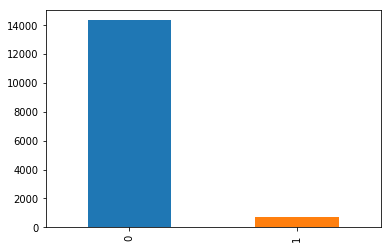

In [7]:
%matplotlib inline
df_train.y.value_counts().plot(kind='bar',)
df_train.y.value_counts()

从上图我们可以看出，约4.6%为逾期高风险用户，其他95.4%为低风险用户

我们使用 ROC-AUC 来评估模型性能。如果你之前没用过该指标，随机猜测可以是 0.5 分，完美的召回率和精确率是 1.0。

## 决策树

In [8]:
import pydotplus
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier,export_graphviz
def print_graph(clf, feature_names):

    """Print decision tree."""

    graph = export_graphviz(

        clf,

        label="root",

        proportion=True,

        impurity=False, 

        out_file=None, 

        feature_names=feature_names,

        class_names={0: "D", 1: "R"},

        filled=True,

        rounded=True

    )

    graph = pydotplus.graph_from_dot_data(graph)  

    return Image(graph.create_png())

在训练数据上用决策树拟合一个节点（决策规则），查看它在测试集上的性能：

Decision tree ROC-AUC score: 0.665


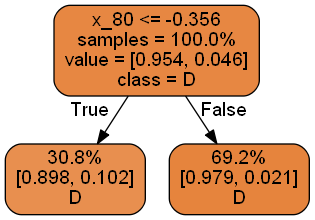

In [9]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)

t1.fit(X_train, y_train)

p = t1.predict_proba(X_test)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

print_graph(t1, X_train.columns)

每个叶节点记录它们在训练样本中的比例、类别分布和类别标签预测。我们的决策树根据X_80否超过 -0.356进行预测：它竟然作出了同样的预测:0.954为低风险，0.046为高风险。但是这没有充分利用我们已有的数据，下面我们使用三层决策规则，看看会得到什么

Decision tree ROC-AUC score: 0.742


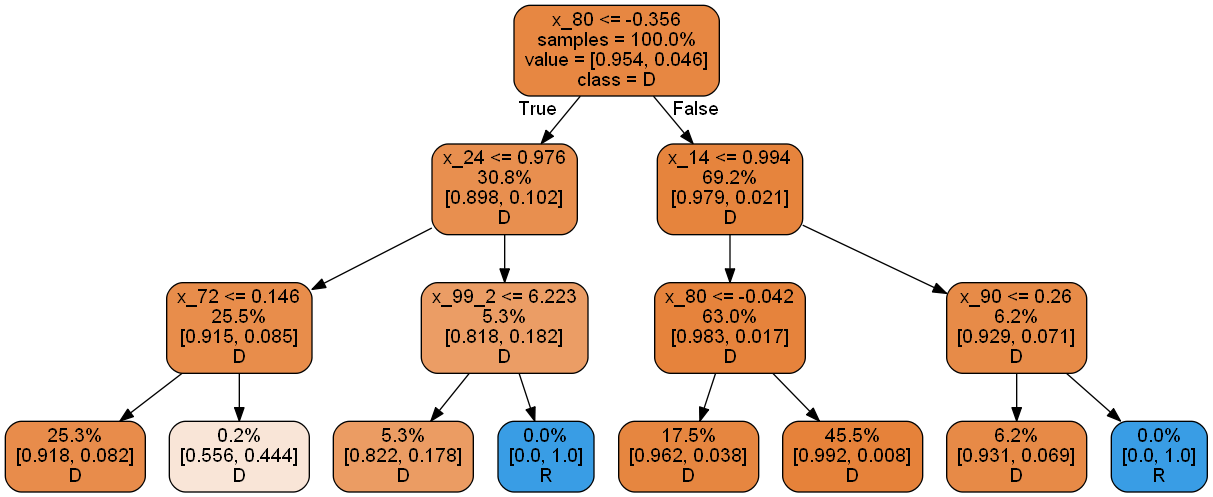

In [10]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)

t2.fit(X_train, y_train)

p = t2.predict_proba(X_test)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

print_graph(t2, X_train.columns)

该模型并不比简单的决策树好太多：预测到的高风险用户比例竟然为0%，低于4.6.观察会发现该决策树使用了很多不确定的分割规则（splitting rule）。

在深度固定的情况下，决策树可以通过增加「宽度」的方式来增加复杂度，即创建多个决策树，并将其连接起来。也就是决策树的集成。想了解这个集成模型为什么会起作用，先要考虑我们如何让决策树探索出比上层树更多的其他模式。

最简单的解决方案就是删除树中较早出现的特征

Decision tree ROC-AUC score: 0.641


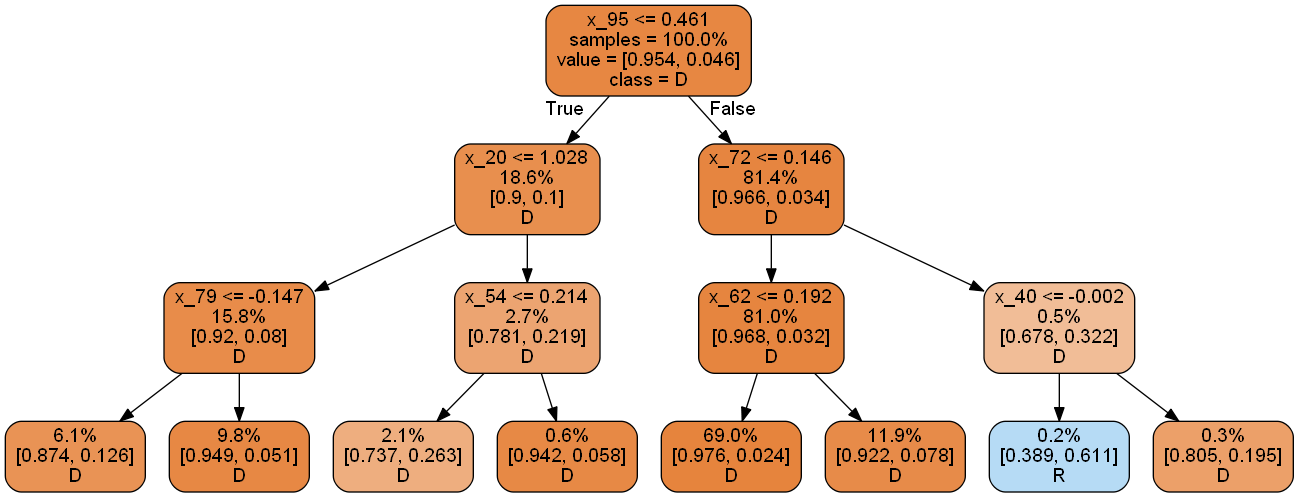

In [11]:
drop = ["x_80"]

xtrain_slim = X_train.drop(drop, 1)

xtest_slim = X_test.drop(drop, 1)


t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)

t3.fit(xtrain_slim, y_train)

p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

print_graph(t3, xtrain_slim.columns)

ROC-AUC 得分与最开始的树得分类似，相比上树分数降低，但是高风险用户比例饿提高至0.2%

## 平均集成
如果集成包含两个以上决策树，则它根据多数原则进行预测。因此，集成对分类器预测结果取平均又叫作多数投票分类器（majority voting classifier）。当集成基于概率取平均时，我们称其为软投票，而对类别标签预测结果取平均被成为硬投票。

In [13]:
p1 = t2.predict_proba(X_test)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]

pd.DataFrame({"full_data": p1,
              "red_data": p2}).corr()

,full_data,red_data
full_data,1.000000,0.393043
red_data,0.393043,1.000000


In [14]:
p1 = t2.predict_proba(X_test)[:, 1]

p2 = t3.predict_proba(xtest_slim)[:, 1]

p = np.mean([p1, p2], axis=0)

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Average of decision tree ROC-AUC score: 0.751


## 集成方法
确实，集成步骤导致分值增加。但是如果我们有更多不同的树，我们甚至可以得到更大的分值。在设计决策树时，我们应该去除哪些特征？

一个快速有效的实践方法是随机地选择一个特征子集，在每个 draw 上拟合一个决策树并平均其预测。这一过程被称为自举平均（bootstrapped averaging，通常缩写为 bagging），它应用于决策树所产生的模型是随机森林。让我们看看随机森林能为我们做什么。我们使用 Scikit-learn 实现构建了 10 个决策树的集成，每一个拟合包含 3 个特征的子集。

In [24]:
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier(
    random_state=SEED
)


gb.fit(X_train, y_train)

p = gb.predict_proba(X_test)[:, 1]

print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(y_test, p))

Average of decision tree ROC-AUC score: 0.795


目前为止，我们看到了集成的两个重要方面：

- 预测误差的关联性越低，效果越好 
- 模型越多，效果越好（前提是模型要好）

出于这一原因，尽可能使用不同模型不失为一个好方法（只要它们表现良好）。目前为止我们一直在依赖简单的平均，但是稍后我们将了解如何使用更复杂的结合。

In [27]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [40]:
def get_models():

    """Generate a library of base learners."""
    lr = LogisticRegression(C=4.0, random_state=SEED)
    rf = RandomForestClassifier(random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    ab = AdaBoostClassifier(random_state=SEED)
    xgb=XGBClassifier()
    lgb=LGBMClassifier()
    models = {'logistic': lr,
              'random forest': rf,
              'gbm': gb,
              'ab':ab,
              'xgb':xgb,
              'lgb':lgb
              }

    return models



def train_predict(model_list):

    """Fit models in list on training set and return preds"""

    P = np.zeros((y_test.shape[0], len(model_list)))

    P = pd.DataFrame(P)


    print("Fitting models.")

    cols = list()

    for i, (name, m) in enumerate(models.items()):

        print("%s..." % name, end=" ", flush=False)

        m.fit(X_train, y_train)

        P.iloc[:, i] = m.predict_proba(X_test)[:, 1]

        cols.append(name)

        print("done")


    P.columns = cols

    print("Done.\n")

    return P



def score_models(P, y):

    """Score model in prediction DF"""

    print("Scoring models.")

    for m in P.columns:

        score = roc_auc_score(y, P.loc[:, m])

        print("%-26s: %.3f" % (m, score))

    print("Done.\n")
    
models = get_models()

P = train_predict(models)

score_models(P, y_test)

Fitting models.
logistic... done
random forest... done
gbm... done
ab... done
xgb... done
lgb... done
Done.

Scoring models.
logistic                  : 0.810
random forest             : 0.671
gbm                       : 0.795
ab                        : 0.786
xgb                       : 0.807
lgb                       : 0.791
Done.



这是我们的基线。logistic效果最好，其次是简单的 xgb。对于我们的集成策略来说，预测误差必须是相对不关联的。

[MLENS] backend: threading
[MLENS] Found 1 residual cache(s):
        1 (4096): C:\Users\yanqiang\AppData\Local\Temp\.mlens_tmp_cache_3m6fy2fj
        Total size: 4096
[MLENS] Removing... done.


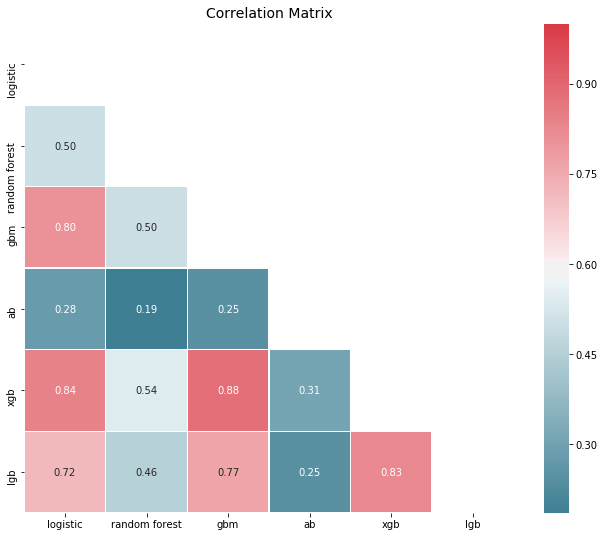

In [33]:
from mlens.visualization import corrmat


corrmat(P.corr(), inflate=False)

plt.show()

In [39]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_test, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.808


## 可视化模型集成的过程

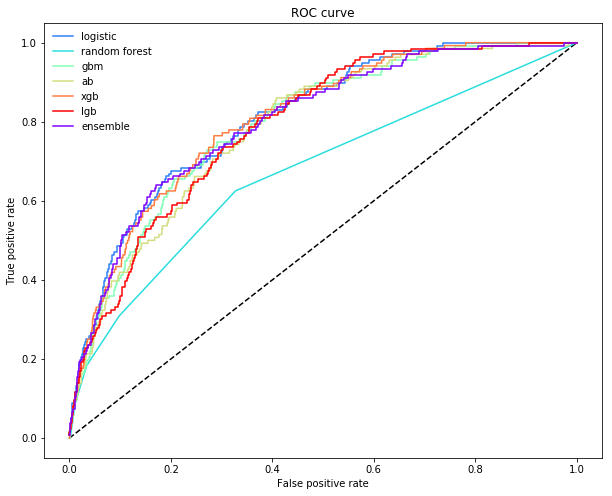

In [36]:
from sklearn.metrics import roc_curve


def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):

    """Plot the roc curve for base learners and ensemble."""

    plt.figure(figsize=(10, 8))

    plt.plot([0, 1], [0, 1], 'k--')


    cm = [plt.cm.rainbow(i)

      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]


    for i in range(P_base_learners.shape[1]):

        p = P_base_learners[:, i]

        fpr, tpr, _ = roc_curve(y_test, p)

        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])


    fpr, tpr, _ = roc_curve(y_test, P_ensemble)

    plt.plot(fpr, tpr, label=ens_label, c=cm[0])


    plt.xlabel('False positive rate')

    plt.ylabel('True positive rate')

    plt.title('ROC curve')

    plt.legend(frameon=False)

    plt.show()



plot_roc_curve(y_test, P.values, P.mean(axis=1), list(P.columns), "ensemble")